In [ ]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from numpy import hstack
from numpy import vstack
from numpy import asarray
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import RidgeCV
#from sklearn.model_selection import RepeatedKFold
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

In [ ]:
###############################################################################
#make function to build superleaner
###############################################################################
def get_models():
	models = list()
#	models.append(LinearRegression())
#	models.append(ElasticNet())
#	models.append(SVR(gamma='scale'))
	models.append(XGBRegressor(max_depth=5,learning_rate=0.1))
	models.append(DecisionTreeRegressor())
#	models.append(KNeighborsRegressor())
	models.append(AdaBoostRegressor())
	models.append(BaggingRegressor(n_estimators=10))
	models.append(RandomForestRegressor(n_estimators=10))
	models.append(ExtraTreesRegressor(n_estimators=10))
	return models

def get_out_of_fold_predictions(X, y, models):
	meta_X, meta_y = list(), list()
	# define split of data
	kfold = KFold(n_splits=10, shuffle=True)
#	kfold = RepeatedKFold(n_splits=10, n_repeats=3)
	# enumerate splits
	for train_ix, test_ix in kfold.split(X):
		fold_yhats = list()
		# get data
		train_X, test_X = X[train_ix], X[test_ix]
		train_y, test_y = y[train_ix], y[test_ix]
		meta_y.extend(test_y)
		# fit and make predictions with each sub-model
		for model in models:
			model.fit(train_X, train_y)
			yhat = model.predict(test_X)
			# store columns
			fold_yhats.append(yhat.reshape(len(yhat),1))
		# store fold yhats as columns
		meta_X.append(hstack(fold_yhats))
	return vstack(meta_X), asarray(meta_y)

def fit_base_models(X, y, models):
	for model in models:
		model.fit(X, y)
        
def fit_meta_model(X, y):
#	model = TransformedTargetRegressor(regressor=RidgeCV(),
#                                    transformer=QuantileTransformer(n_quantiles=300,
#                                    output_distribution='normal'))
    model = RidgeCV()
    model.fit(X, y)
    return model

def evaluate_models(X, y, models):
	for model in models:
		yhat = model.predict(X)
		mae = mean_absolute_error(y, yhat)
		print('%s: MAE %.3f' % (model.__class__.__name__, mae))

# make predictions with stacked model
def super_learner_predictions(X, models, meta_model):
	meta_X = list()
	for model in models:
		yhat = model.predict(X)
		meta_X.append(yhat.reshape(len(yhat),1))
	meta_X = hstack(meta_X)
	# predict
	return meta_model.predict(meta_X)


In [ ]:
#############################################################################
#import dataset
#############################################################################
df = pd.read_csv('esp data train clear 2019.csv',sep=';')
df2 = pd.read_csv('data u55 2020 clear.csv')

In [ ]:
#############################################################################
##Data Pre-processing
#############################################################################
import re
def prep(df):
    df = df.dropna()
    KA = list(df.iloc[:,0])
    Pi = list(df['Pi'])
    Ti = list(df['Ti'])
    Tm = list(df['Tm'])
    VSDamp = list(df['VSD amps'])
    VSDout = list(df['VSD out'])
    Vib = list(df['Vib'])
    current = list(df['current'])
    net = list(df['net(bopd)'])
    motoramp = list(df['motor amp'])
    for i in range(len(df)):
        df.iloc[i,0] = float(re.sub(",",".",KA[i]))
        df.iloc[i,2] = float(re.sub(",",".",Pi[i]))
        df.iloc[i,5] = float(re.sub(",",".",Ti[i]))
        df.iloc[i,6] = float(re.sub(",",".",Tm[i]))
        df.iloc[i,7] = float(re.sub(",",".",VSDamp[i]))
        df.iloc[i,8] = float(re.sub(",",".",VSDout[i]))
        df.iloc[i,9] = float(re.sub(",",".",Vib[i]))
        df.iloc[i,11] = float(re.sub(",",".",current[i]))
        df.iloc[i,17] = float(re.sub(",",".",net[i]))
        df.iloc[i,15] = float(re.sub(",",".",motoramp[i]))
        df.iloc[i,12] = int(df.iloc[i,12])
    return df

df = prep(df)

In [ ]:
############################################################################
#Data preparation
############################################################################    
# feature for train model 1
X = df.iloc[:,[0,2,3,4,5,6,8,9,11,12,14,18]].values
y = df.iloc[:, 17].values
y = y.reshape(-1,1)


#feature for test pred
Xpred = df2.iloc[:,[0,2,3,4,5,6,8,9,11,12,14,18]].values
ypred = df2.iloc[:, 17].values
ypred = ypred.reshape(-1,1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
norm_X = MinMaxScaler()
norm_y = MinMaxScaler()
X_norm = norm_X.fit_transform(X)
y_norm = norm_y.fit_transform(y)
Xpred_norm = norm_X.fit_transform(Xpred)
ypred_norm = norm_y.fit_transform(ypred)

In [ ]:
###########################################################################
#data training and modeling
###########################################################################
import warnings
warnings.filterwarnings("ignore")
# get models
xgb = XGBRegressor(max_depth=5,learning_rate=0.1)
dtr = DecisionTreeRegressor()
adr = AdaBoostRegressor()
br = BaggingRegressor(n_estimators=10)
rfr = RandomForestRegressor(n_estimators=10)
etr = ExtraTreesRegressor(n_estimators=10)

xgb.fit(X_norm,y_norm)
dtr.fit(X_norm,y_norm)
adr.fit(X_norm,y_norm)
br.fit(X_norm,y_norm)
rfr.fit(X_norm,y_norm)
etr.fit(X_norm,y_norm)

models = get_models()

# get out of fold predictions
meta_X, meta_y = get_out_of_fold_predictions(X_norm, y_norm, models)
print('Meta ', meta_X.shape, meta_y.shape)

# fit base models
fit_base_models(X_norm, y_norm, models)

# fit the meta model
meta_model = fit_meta_model(meta_X, meta_y)

# evaluate base models
#evaluate_models(X_val, y_val, models)
evaluate_models(Xpred_norm, 
                ypred_norm, models)

# evaluate meta model
#yhat = super_learner_predictions(X_val, models, meta_model)
#print('Super Learner: RMSE %.3f' % (sqrt(mean_squared_error(y_val, yhat))))

yhat = super_learner_predictions(Xpred_norm, models, meta_model)
print('Super Learner: MAE %.3f' % (mean_absolute_error(ypred_norm, 
                                                        yhat)))

[23:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:43:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:43:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:43:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:43:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:43:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:43:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

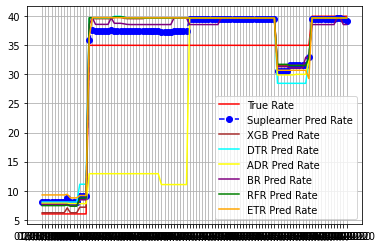

In [ ]:
###########################################################################
#data visualization
###########################################################################
def invx(X):
    x = norm_X.inverse_transform(X)
    return x
def invy(y):
    Y = norm_y.inverse_transform(y)
    return Y
xgbpred = invy(xgb.predict(Xpred_norm).reshape(-1,1))
dtrpred = invy(dtr.predict(Xpred_norm).reshape(-1,1))
adrpred = invy(adr.predict(Xpred_norm).reshape(-1,1))
brpred = invy(br.predict(Xpred_norm).reshape(-1,1))
rfrpred = invy(rfr.predict(Xpred_norm).reshape(-1,1))
etrpred = invy(etr.predict(Xpred_norm).reshape(-1,1))
vyhat = invy(yhat.reshape(-1,1))

tgl = df2.iloc[:,21]

plt.plot(tgl,ypred,color='red',label='True Rate')
plt.plot(tgl,vyhat,color='blue',marker='o',ls='dashed',label='Suplearner Pred Rate')
plt.plot(tgl,xgbpred,color='brown',label='XGB Pred Rate')
plt.plot(tgl,dtrpred,color='cyan',label='DTR Pred Rate')
plt.plot(tgl,adrpred,color='yellow',label='ADR Pred Rate')
plt.plot(tgl,brpred,color='purple',label='BR Pred Rate')
plt.plot(tgl,rfrpred,color='green',label='RFR Pred Rate')
plt.plot(tgl,etrpred,color='orange',label='ETR Pred Rate')
#plt.plot(tgl,predictions,color='black',label='Pred Rate cv')
plt.legend()
plt.grid()

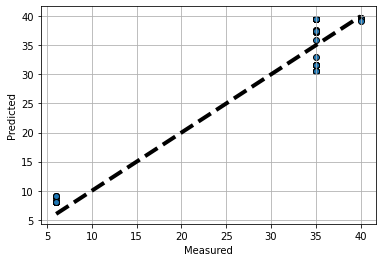

In [ ]:
fig, ax = plt.subplots()
ax.scatter(ypred, vyhat, edgecolors=(0, 0, 0))
ax.plot([ypred.min(), ypred.max()], [ypred.min(), ypred.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.grid()
plt.show()

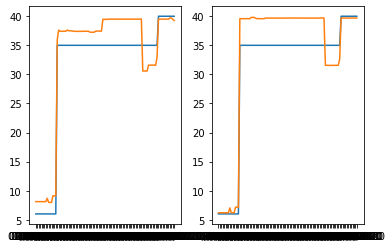

In [ ]:
fig, (axs1,axs2) = plt.subplots(1, 2)
axs1.plot(tgl, ypred)
axs1.plot(tgl, vyhat)
axs2.plot(tgl, ypred)
axs2.plot(tgl, xgbpred)
#axs[1, 0].plot(x, -y, 'tab:green')
#axs[1, 1].plot(x, -y, 'tab:red')